In [1]:
import os
import glob
import bz2
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# Specifying filename and directory
data_dir = os.getcwd() + '/data'
quotebank_dir = data_dir + "/Quotebank"
quotebank_bz2 = os.listdir(quotebank_dir)
print(quotebank_bz2)

# Change directory
os.chdir(quotebank_dir)

['.DS_Store', 'quotes-2020-movies.json.bz2', 'quotes-2015-movies.json.bz2', 'quotes-2017-movies.json.bz2', 'quotes-2018-movies.json.bz2', 'quotes-2016-movies.json.bz2', 'quotes-2019-movies.json.bz2']


In [3]:
df = pd.DataFrame()
for year_file in tqdm(quotebank_bz2):
    if year_file != '.DS_Store':
        temp =  pd.read_json(year_file, lines=True, compression='bz2')
        df = pd.concat([df, temp], ignore_index = True) 
df.shape

  0%|          | 0/7 [00:00<?, ?it/s]

(67736, 10)

In [4]:
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,movie
0,2020-02-04-010360,Birds of Prey has already been lauded for its ...,None,[],2020-02-04 16:17:42,1,"[[None, 0.9588], [Alex Ross, 0.0412]]",[https://nerdist.com/article/dc-birds-of-prey-...,E,Birds of Prey: And the Fantabulous Emancipatio...
1,2020-02-06-011469,Birds of Prey: The Fantabulous Emancipation of...,None,[],2020-02-06 09:35:03,2,"[[None, 0.872], [Jon Valera, 0.128]]",[https://www.nbcnews.com/news/asian-america/bi...,E,Birds of Prey: And the Fantabulous Emancipatio...
2,2020-02-28-090827,"with the short and said, `We'd like to go with...",None,[],2020-02-28 22:02:10,1,"[[None, 0.6415], [Al Jean, 0.3585]]",[https://comicbook.com/tv-shows/2020/02/28/the...,E,Onward
3,2020-01-10-009513,Birds of Prey: The Album.,None,[],2020-01-10 13:54:31,57,"[[None, 0.6859], [Jurnee Smollett-Bell, 0.0772...",[https://www.aceshowbiz.com/news/view/00147273...,E,Birds of Prey: And the Fantabulous Emancipatio...
4,2020-02-19-090077,Thrilled to announce that I will perform the e...,Brandi Carlile,[Q164060],2020-02-19 20:30:15,1,"[[Brandi Carlile, 0.543], [None, 0.3348], [Myc...",[https://klaw.com/brandi-carlile-carried-me-wi...,E,Onward


Removing NaN-values. We see that these only occur in the `movie` attribute which right now is due to an issue in the data filtering. 

In [5]:
df.isnull().any()

quoteID           False
quotation         False
speaker           False
qids              False
date              False
numOccurrences    False
probas            False
urls              False
phase             False
movie             False
dtype: bool

In [6]:
df = df.loc[-df.isnull().any(axis=1)]

In [7]:
df.shape

(67736, 10)

### Dealing with the speakers

We investigate how many quotes does not have an obvious speaker and is denoted by 'None'. Turns out that it is approximately 38%.

In [8]:
number_none_speakers = len(df[df.speaker == 'None'])

print(f"'None'-speakers: {number_none_speakers}")
print(f"Total fraction of 'None'-speakers: {number_none_speakers / len(df)}")

'None'-speakers: 25588
Total fraction of 'None'-speakers: 0.37776071808196526


Even though the single speakers are not really important for answering our research questions, we choose to clean the data by chaning 'None'-speakers to the speaker with second highest probability from the `df.probas` attribute. 
<span style="color:red"> *TODO*: THIS MIGHT NEED RE-ENGENEERING TO A MORE EXCLUSIVE THING. right now trump gets assigned to a lot. </span>

In [9]:
# Removes speaker as being None to being the second most likely in case speaker is 'None'
proba_threshhold = 0.15

secondary_speaker = [df['probas'][i][1][0] if (speaker == 'None') and (float(df['probas'][i][1][1]) > proba_threshhold) else speaker for i, speaker in enumerate(tqdm(df['speaker']))]
df['speaker'] = secondary_speaker

  0%|          | 0/67736 [00:00<?, ?it/s]

In [10]:
number_none_speakers = len(df[df.speaker == 'None'])

print(f"'None'-speakers: {number_none_speakers}")
print(f"Total fraction of 'None'-speakers: {number_none_speakers / len(df)}")

'None'-speakers: 10121
Total fraction of 'None'-speakers: 0.14941832998700838


In [11]:
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,movie
0,2020-02-04-010360,Birds of Prey has already been lauded for its ...,None,[],2020-02-04 16:17:42,1,"[[None, 0.9588], [Alex Ross, 0.0412]]",[https://nerdist.com/article/dc-birds-of-prey-...,E,Birds of Prey: And the Fantabulous Emancipatio...
1,2020-02-06-011469,Birds of Prey: The Fantabulous Emancipation of...,None,[],2020-02-06 09:35:03,2,"[[None, 0.872], [Jon Valera, 0.128]]",[https://www.nbcnews.com/news/asian-america/bi...,E,Birds of Prey: And the Fantabulous Emancipatio...
2,2020-02-28-090827,"with the short and said, `We'd like to go with...",Al Jean,[],2020-02-28 22:02:10,1,"[[None, 0.6415], [Al Jean, 0.3585]]",[https://comicbook.com/tv-shows/2020/02/28/the...,E,Onward
3,2020-01-10-009513,Birds of Prey: The Album.,None,[],2020-01-10 13:54:31,57,"[[None, 0.6859], [Jurnee Smollett-Bell, 0.0772...",[https://www.aceshowbiz.com/news/view/00147273...,E,Birds of Prey: And the Fantabulous Emancipatio...
4,2020-02-19-090077,Thrilled to announce that I will perform the e...,Brandi Carlile,[Q164060],2020-02-19 20:30:15,1,"[[Brandi Carlile, 0.543], [None, 0.3348], [Myc...",[https://klaw.com/brandi-carlile-carried-me-wi...,E,Onward


Furthermore, we realize that there is a super specific timestamp on the `date` attribute. Later on we will match daily box office sales with the Quotebank data, so we strip the timestamps from the specific time of the date and focus solely on the date.

In [12]:
# Remove last part of date from the quoteID date string to be able to have an average daily sentiment score
reduced_dates = [("-").join(date.split("-")[:3]) for date in tqdm(df.quoteID)]
df['date'] = reduced_dates

  0%|          | 0/67736 [00:00<?, ?it/s]

In [13]:
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,movie
0,2020-02-04-010360,Birds of Prey has already been lauded for its ...,None,[],2020-02-04,1,"[[None, 0.9588], [Alex Ross, 0.0412]]",[https://nerdist.com/article/dc-birds-of-prey-...,E,Birds of Prey: And the Fantabulous Emancipatio...
1,2020-02-06-011469,Birds of Prey: The Fantabulous Emancipation of...,None,[],2020-02-06,2,"[[None, 0.872], [Jon Valera, 0.128]]",[https://www.nbcnews.com/news/asian-america/bi...,E,Birds of Prey: And the Fantabulous Emancipatio...
2,2020-02-28-090827,"with the short and said, `We'd like to go with...",Al Jean,[],2020-02-28,1,"[[None, 0.6415], [Al Jean, 0.3585]]",[https://comicbook.com/tv-shows/2020/02/28/the...,E,Onward
3,2020-01-10-009513,Birds of Prey: The Album.,None,[],2020-01-10,57,"[[None, 0.6859], [Jurnee Smollett-Bell, 0.0772...",[https://www.aceshowbiz.com/news/view/00147273...,E,Birds of Prey: And the Fantabulous Emancipatio...
4,2020-02-19-090077,Thrilled to announce that I will perform the e...,Brandi Carlile,[Q164060],2020-02-19,1,"[[Brandi Carlile, 0.543], [None, 0.3348], [Myc...",[https://klaw.com/brandi-carlile-carried-me-wi...,E,Onward


The attribute `phase` seem to mostly take the values 'E'. The investigation below shows that all of the entries are in fact 'E' so we decide to remove it from the dataframe. From the documentation of the data we also do not find it relevant for our case. Also we won't be using the `quoteID` attribute but instead the WikiData compatible `qids`.

In [14]:
np.unique(df.phase, return_counts=True)
df = df.drop(['phase', 'quoteID'], axis=1)

### Handling outliers in the numOccurrences

We want to check for outliers in the number of occurrences as it is the only numercal attribute left. By a first descriptive analysis of the variable we suspect something fishy as the maximum number is quite high. We note that there are no weird values on the other side as the minimum value of occurrences is 1.

In [15]:
df.numOccurrences.describe()

count    67736.000000
mean         8.763700
std        444.275087
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max      58945.000000
Name: numOccurrences, dtype: float64

We also want to see if this seems unfeasible when looking at the plots. The boxplot reveals that there is a need to investigate outliers and the plot of the occurences reveal that the distribution seem to follow a strong power law. We will have to deal with outliers to get anything meaningful from the data.

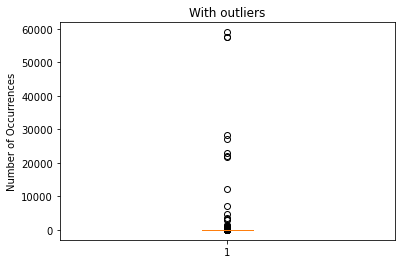

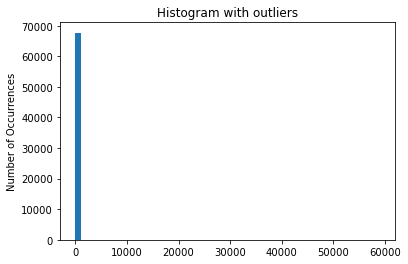

In [16]:
plt.boxplot(df.numOccurrences)
plt.ylabel("Number of Occurrences")
plt.title("With outliers")
plt.show()

plt.hist(df.numOccurrences, bins=50)
plt.ylabel("Number of Occurrences")
plt.title("Histogram with outliers")
plt.show()

As a start we will investigate whether the IQR outlier removal approach is feasible for our data. The code is taken and re-written from our homework 1 hand-in.


In [17]:
def get_outliers(data):
    """ Filters out outliers that is more than 1.5 times lower than the 25% quantile and above 1.5 times higher than the 
    75% quantile.
    
    Input is the sub-dataframe consisting of the columns assosiacted with kilometrage data.
    returns the indeces for rows that contains outliers.
    
    Function idea is taken from our implementation in Homework 1
    
    """
    
    series = pd.Series(data)
    
    IQR = (series.quantile(0.75) - series.quantile(0.25)) 
    outlier_threshold = IQR * 1.5

    # calculating decision boundaries
    lower = series.quantile(0.25)-outlier_threshold
    upper = series.quantile(0.75)+outlier_threshold

    # Finds the union of outlier indeces from the previous column and the current column
    outlier_indeces = np.union1d(series.index[series < lower], series.index[series > upper])

    return np.array([int(x) for x in outlier_indeces])

In [18]:
outlier_ids = get_outliers(df.numOccurrences)
print(f"Number of IQR outliers: {len(outlier_ids)}")
print(f"Ratio of IQR outliers in original data: {len(outlier_ids)/len(df)}")

Number of IQR outliers: 10679
Ratio of IQR outliers in original data: 0.15765619463800637


In [19]:
df = df.drop(outlier_ids)
df.index = np.arange(len(df))
df.shape

(57057, 8)

So 15% of the data was determined to be outliers based on the IQR range. We visualize the new distribution in the following. 

In [20]:
df.describe()

,numOccurrences
count,57057.000000
mean,1.365617
std,0.625762
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,3.000000


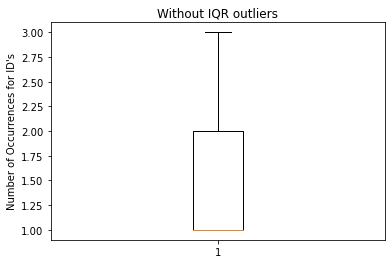

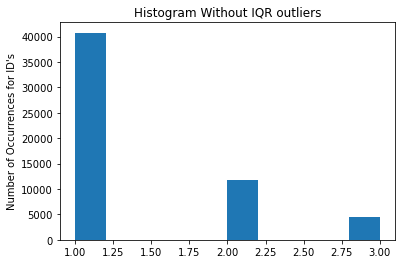

In [21]:
plt.boxplot(df.numOccurrences)
plt.ylabel("Number of Occurrences for ID's")
plt.title("Without IQR outliers")
plt.show()

plt.hist(df.numOccurrences)
plt.ylabel("Number of Occurrences for ID's")
plt.title("Histogram Without IQR outliers")
plt.show()

In [22]:
df.head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
0,Birds of Prey has already been lauded for its ...,None,[],2020-02-04,1,"[[None, 0.9588], [Alex Ross, 0.0412]]",[https://nerdist.com/article/dc-birds-of-prey-...,Birds of Prey: And the Fantabulous Emancipatio...
1,Birds of Prey: The Fantabulous Emancipation of...,None,[],2020-02-06,2,"[[None, 0.872], [Jon Valera, 0.128]]",[https://www.nbcnews.com/news/asian-america/bi...,Birds of Prey: And the Fantabulous Emancipatio...
2,"with the short and said, `We'd like to go with...",Al Jean,[],2020-02-28,1,"[[None, 0.6415], [Al Jean, 0.3585]]",[https://comicbook.com/tv-shows/2020/02/28/the...,Onward
3,Thrilled to announce that I will perform the e...,Brandi Carlile,[Q164060],2020-02-19,1,"[[Brandi Carlile, 0.543], [None, 0.3348], [Myc...",[https://klaw.com/brandi-carlile-carried-me-wi...,Onward
4,Sonic the Hedgehog might not become a kid-movi...,Brian Truitt,[],2020-02-14,1,"[[None, 0.7308], [Brian Truitt, 0.179], [Micha...",[http://www.gamespot.com/articles/sonic-the-he...,Sonic the Hedgehog


### Dealing with the quoter-IDs

Furthermore, we see that the `qids` might need some engineering. In the initial analyses on the 2019 NYT data we saw that some individuals are quoted differently even though it's in fact the same speaker. For instance this was the case for the speaker "Donald Trump" and "President Trump". In this case these two denotations share a common qID for which reason we would want to be able to get all quotes from Donald Trump and President Trump when searching for them independently. Even though it might not be as important with movies, we deem it good practice to regulate this behaviour. We start by engineering empty quoteID-lists as an unknown token.

In [23]:
empty = np.array([entry for entry, qID_list in enumerate(df.qids) if len(qID_list) == 0])
print(f"Number of currently unknown qids: {len(empty)}")

Number of currently unknown qids: 21461


In [24]:
pd.options.mode.chained_assignment = None
df['qids'][empty] = [['<UNK>']] * len(empty)

df.qids.head()

0      [<UNK>]
1      [<UNK>]
2      [<UNK>]
3    [Q164060]
4      [<UNK>]
Name: qids, dtype: object

Using this '\<UNK>' token we are able to search the df to replace this token with a qID if the speaker occurs with a qID another place in the data. In this manner all qIDs of a specified speaker will be the full list of qIDs associated with that speaker.

In [25]:
def set_qID(speaker, df):
    #Extract qID's of a speaker
    qIDs = {speaker: list({quote_ID for quote_IDlist in df.qids[df['speaker'] == speaker] for quote_ID in quote_IDlist})}
    
    # Conditions for removing the <UNK> token.
    if len(qIDs[speaker]) > 1 and '<UNK>' in qIDs[speaker]:
        qIDs[speaker].remove('<UNK>')
    
    # Creating new qIDs for replacing in original dataframe
    speaker_indeces = np.where(df.speaker == speaker)[0]
    replacement = pd.Series([qIDs[speaker]] * (sum(df['speaker'] == speaker)), index=speaker_indeces)
    
    # Replace
    df.qids[df['speaker'] == speaker] = replacement

This now works, which can be seen on the speaker George Lucas in the following cells.

In [26]:
df[df.speaker == 'George Lucas'].head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
472,"When I started to go into Star Wars, [ my frie...",George Lucas,"[Q1507803, Q38222]",2015-12-31,1,"[[George Lucas, 0.7612], [Colin Trevorrow, 0.1...",[http://theindianrepublic.com/i-sold-star-wars...,Star Wars: Episode VII - The Force Awakens
486,"After `Star Wars,' I went back to Warner Bros....",George Lucas,"[Q1507803, Q38222]",2015-04-19,1,"[[George Lucas, 0.6949], [None, 0.1538], [Step...",[http://sfgate.com/technology/businessinsider/...,Star Wars: Episode VII - The Force Awakens
509,a Star Wars for girls,George Lucas,[<UNK>],2015-01-27,1,"[[None, 0.5037], [George Lucas, 0.4963]]",[http://www.comicmix.com/2015/01/27/box-office...,Star Wars: Episode VII - The Force Awakens
523,We became friends and then we started dating a...,George Lucas,"[Q1507803, Q38222]",2015-12-19,2,"[[George Lucas, 0.5894], [None, 0.4106]]",[http://feeds.businessinsider.com.au/~/1290472...,Star Wars: Episode VII - The Force Awakens
540,I might use the lightsaber instead of a torch ...,George Lucas,[<UNK>],2015-10-30,2,"[[None, 0.8296], [George Lucas, 0.1704]]",[http://dailyliberal.com.au/story/3459543/movi...,Star Wars: Episode VII - The Force Awakens


In [27]:
# Calling the function
set_qID('George Lucas', df)

df[df.speaker == 'George Lucas'].head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
472,"When I started to go into Star Wars, [ my frie...",George Lucas,"[Q38222, Q1507803]",2015-12-31,1,"[[George Lucas, 0.7612], [Colin Trevorrow, 0.1...",[http://theindianrepublic.com/i-sold-star-wars...,Star Wars: Episode VII - The Force Awakens
486,"After `Star Wars,' I went back to Warner Bros....",George Lucas,"[Q38222, Q1507803]",2015-04-19,1,"[[George Lucas, 0.6949], [None, 0.1538], [Step...",[http://sfgate.com/technology/businessinsider/...,Star Wars: Episode VII - The Force Awakens
509,a Star Wars for girls,George Lucas,"[Q38222, Q1507803]",2015-01-27,1,"[[None, 0.5037], [George Lucas, 0.4963]]",[http://www.comicmix.com/2015/01/27/box-office...,Star Wars: Episode VII - The Force Awakens
523,We became friends and then we started dating a...,George Lucas,"[Q38222, Q1507803]",2015-12-19,2,"[[George Lucas, 0.5894], [None, 0.4106]]",[http://feeds.businessinsider.com.au/~/1290472...,Star Wars: Episode VII - The Force Awakens
540,I might use the lightsaber instead of a torch ...,George Lucas,"[Q38222, Q1507803]",2015-10-30,2,"[[None, 0.8296], [George Lucas, 0.1704]]",[http://dailyliberal.com.au/story/3459543/movi...,Star Wars: Episode VII - The Force Awakens


We want to apply this functionality to the full dataframe (meaning all individual speakers) for which reason we extract the individual speaker names and how frequently quoted they are. We calculate the number of unique quotes for each speaker even though we find it more relevant to do outlier detection based on total number of occurences (`numOccurrences` attribute). This will be done later in the pipeline.

In [28]:
speakers, freq_unsorted = np.unique(df.speaker, return_counts=True)
freq, speakers = np.array(list(zip(*sorted(zip(freq_unsorted, speakers), reverse=True))))

print("Top 10 quoted speakers (w/o numOccurences): ")
list(zip(speakers[:10], freq[:10]))

Top 10 quoted speakers (w/o numOccurences): 


[('None', '8351'),
 ('Kevin Feige', '1167'),
 ('Captain Marvel', '854'),
 ('Tom Holland', '550'),
 ('Joe Russo', '518'),
 ('J.J. Abrams', '514'),
 ('Bob Iger', '451'),
 ('Kathleen Kennedy', '437'),
 ('Rian Johnson', '432'),
 ('George Lucas', '377')]

In [29]:
for speaker in tqdm(speakers):
    set_qID(speaker, df=df)

  0%|          | 0/13650 [00:00<?, ?it/s]

Now, the only way there would be qID's of the name '\<UNK>' would be if the assignment of the predicted speaker is less than 15% percent certain (see `proba_threshhold` in the removal of None-type speakers) and if that same speaker does not have a qID throughout all of the dataframe. In this case we find evidence for deleting the rows.

In [30]:
UNK_idxs = np.array([], dtype=int)
for i, qID in enumerate(tqdm(df.qids)):
    if '<UNK>' in qID:
        UNK_idxs = np.append(UNK_idxs, i)

  0%|          | 0/57057 [00:00<?, ?it/s]

In [31]:
df = df.drop(UNK_idxs)
df.index = np.arange(len(df))
df.shape

(44970, 8)

The following function then concatenates the qID's of speakers if they have more than one qID in common, such that we get exactly the basis for a shared ID if two speakers (like Donald Trump and President Trump) are in fact the same.

In [32]:
def mergeQuoteIDs(df):
    qID_dict = defaultdict(dict)
    print("Creating qID dictionary...")
    for document_number, qid_list in enumerate(tqdm(df.qids)):
        for qid in qid_list:
            if qid in qID_dict:
                qID_dict[qid].append(document_number)
            else:
                qID_dict[qid] = [document_number]
    
    print("Gathering qIDs across documents...")
    new_column = {}
    for document_number, qid_list in enumerate(tqdm(df.qids)):
        document_IDs = []
        for qid in qid_list:
            document_IDs.append(qID_dict[qid])

        related_docs = set(np.concatenate(document_IDs))
        new_qids = list(set(np.concatenate(list(df.qids[related_docs]))))

        new_column[document_number] = new_qids

    df['qids'] = pd.Series(new_column)

In [33]:
mergeQuoteIDs(df)
df.head()

Creating qID dictionary...


  0%|          | 0/44970 [00:00<?, ?it/s]

Gathering qIDs across documents...


  0%|          | 0/44970 [00:00<?, ?it/s]

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
0,"with the short and said, `We'd like to go with...",Al Jean,[Q2829373],2020-02-28,1,"[[None, 0.6415], [Al Jean, 0.3585]]",[https://comicbook.com/tv-shows/2020/02/28/the...,Onward
1,Thrilled to announce that I will perform the e...,Brandi Carlile,[Q164060],2020-02-19,1,"[[Brandi Carlile, 0.543], [None, 0.3348], [Myc...",[https://klaw.com/brandi-carlile-carried-me-wi...,Onward
2,Sonic the Hedgehog might not become a kid-movi...,Brian Truitt,[Q24387573],2020-02-14,1,"[[None, 0.7308], [Brian Truitt, 0.179], [Micha...",[http://www.gamespot.com/articles/sonic-the-he...,Sonic the Hedgehog
3,The animals do what he wants but operate in co...,Stephen Gaghan,[Q1971984],2020-01-24,1,"[[Stephen Gaghan, 0.7508], [None, 0.2492]]",[http://nst.com.my/lifestyle/groove/2020/01/55...,Dolittle
4,`Dolittle' is a more harmless and whimsical fa...,Robert Downey,[Q165219],2020-01-18,1,"[[Robert Downey, 0.6829], [None, 0.2553], [Kat...",[http://gulfnews.com/entertainment/hollywood/r...,Dolittle


And then we create a new ID for each unique list of qID's.

In [34]:
def newID(df):
    unique_IDlists = np.unique(df['qids'])
    newIDs = []
    
    for row_qIDlist in tqdm(df.qids):
        for newID, unique_list in enumerate(unique_IDlists):
            if unique_list == row_qIDlist:
                newIDs.append(newID)
    df['shared_ID'] = newIDs
    
    return newIDs

In [35]:
newIDs = newID(df)

  0%|          | 0/44970 [00:00<?, ?it/s]

In [36]:
df.head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID
0,"with the short and said, `We'd like to go with...",Al Jean,[Q2829373],2020-02-28,1,"[[None, 0.6415], [Al Jean, 0.3585]]",[https://comicbook.com/tv-shows/2020/02/28/the...,Onward,3855
1,Thrilled to announce that I will perform the e...,Brandi Carlile,[Q164060],2020-02-19,1,"[[Brandi Carlile, 0.543], [None, 0.3348], [Myc...",[https://klaw.com/brandi-carlile-carried-me-wi...,Onward,1168
2,Sonic the Hedgehog might not become a kid-movi...,Brian Truitt,[Q24387573],2020-02-14,1,"[[None, 0.7308], [Brian Truitt, 0.179], [Micha...",[http://www.gamespot.com/articles/sonic-the-he...,Sonic the Hedgehog,3159
3,The animals do what he wants but operate in co...,Stephen Gaghan,[Q1971984],2020-01-24,1,"[[Stephen Gaghan, 0.7508], [None, 0.2492]]",[http://nst.com.my/lifestyle/groove/2020/01/55...,Dolittle,2036
4,`Dolittle' is a more harmless and whimsical fa...,Robert Downey,[Q165219],2020-01-18,1,"[[Robert Downey, 0.6829], [None, 0.2553], [Kat...",[http://gulfnews.com/entertainment/hollywood/r...,Dolittle,1184


### Investigating the new ID's

We will now investigate how different ID's (the shared one) are distributed across quotes. We calculate the frequency with which ID is associated, meaning the total number of occurences for each ID.

In [37]:
print(f"Number of unique IDs: {np.max(df.shared_ID)}")

Number of unique IDs: 10252


In [38]:
freq_occurences = defaultdict(dict)

for ID in tqdm(newIDs):
    freq_occurences[ID] = sum(df[df['shared_ID'] == ID].numOccurrences)

  0%|          | 0/44970 [00:00<?, ?it/s]

In [39]:
freq_list = [(ID, count) for ID, count in sorted(freq_occurences.items(), key=lambda item: item[1], reverse=True)]
ID, freq = list(zip(*freq_list))
ID, freq = np.array(ID), np.array(freq)

Using a boxplot we also see that these ones seem to be full of outliers and by plotting the amount of occurrences with the speakers sorted in a descending manner, we see that the distribution looks like a strong power law.

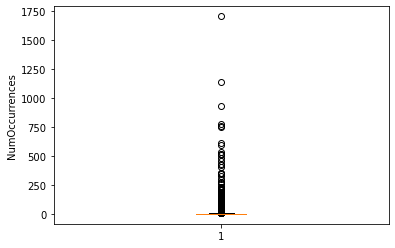

In [40]:
plt.boxplot(freq)
plt.ylabel("NumOccurrences")
plt.show()

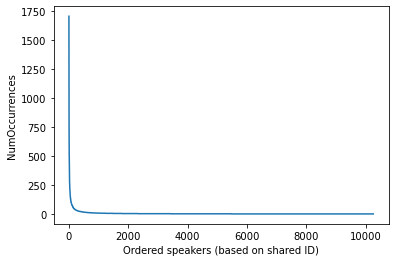

In [41]:
plt.plot(np.arange(len(freq)), freq)
plt.xlabel("Ordered speakers (based on shared ID)")
plt.ylabel("NumOccurrences")
plt.show()

We do not regard this as a problem, since it seems reasonable that this depicts the real-world scenario where some people - like star directors and movie stars - have more to say than actors that are not playing in movies at the current time but still gets quoted once in a while.

By looking at the shared_ID, we now see that the ambiguity of speakers is now reduced - which will be useful in further analyses - as the new `shared_ID` attribute captures identical speaker denoted by different names.

In [42]:
N = 25
topN = []

print(f"Most quoted ID's: \n (shared_ID, total numOccurrences, associated speakers)\n")
for n in range(N):
    
    idxs = [i for (i, shared) in enumerate(df.shared_ID) if shared == ID[n]]
    associated_speakers = df.iloc[idxs, :].speaker.unique()
    
    info_tuple = (ID[n], freq[n], list(associated_speakers))
    topN.append(info_tuple)
    
    print(f"{n+1}) {topN[n]}\n")

Most quoted ID's: 
 (shared_ID, total numOccurrences, associated speakers)

1) (6646, 1705, ['Kevin Feige', 'KEVIN FEIGE'])

2) (5295, 1138, ['Captain Marvel'])

3) (1825, 930, ['J.J. Abrams', 'JJ Abrams', 'J. J. Abrams', 'jj abrams', 'J J Abrams', 'J.J. ABRAMS'])

4) (9891, 777, ['Tom Holland', 'TOM HOLLAND'])

5) (3222, 755, ['Joe Russo', 'Joseph Russo', 'joe russo'])

6) (7061, 748, ['Bob Iger', 'Robert Iger', 'Robert A. Iger', 'BOB IGER'])

7) (8311, 614, ['Rian Johnson', 'RIAN JOHNSON'])

8) (2981, 593, ['Kathleen Kennedy'])

9) (5671, 539, ['Patty Jenkins', 'PATTY JENKINS', 'patty Jenkins'])

10) (1184, 518, ['Robert Downey', 'ROBERT DOWNEY JR. .', 'Robert Downey Jr. .'])

11) (1732, 517, ['Gal Gadot'])

12) (5135, 509, ['George Lucas', 'GEORGE LUCAS'])

13) (2389, 487, ['Mark Hamill', 'MARK HAMILL'])

14) (1379, 456, ['John Boyega'])

15) (3038, 428, ['Taika Waititi', 'TAIKA WAITITI'])

16) (7202, 420, ['Chris Hemsworth', 'chris hemsworth', 'CHRIS HEMSWORTH'])

17) (1893, 409, [

### Add sentiment of quotes

We use the `Afinn` sentiment lexicon for mapping a sentiment score to each quote in the preprocessed Quotebank data.

In [43]:
!pip install Afinn
from afinn import Afinn

In [44]:
afn = Afinn()
sentiments = [afn.score(quote) for quote in tqdm(df.quotation)]
df['sentiment'] = sentiments

  0%|          | 0/44970 [00:00<?, ?it/s]

And now we see the average, max, min, etc. of the attribute.

In [45]:
df.sentiment.describe()

count    44970.000000
mean         2.539827
std          5.528586
min        -45.000000
25%          0.000000
50%          1.000000
75%          5.000000
max         89.000000
Name: sentiment, dtype: float64

The dataframe is saved as a pickle and we investigate the sentiment further in the `sentiment.ipynb` file.

In [46]:
# Save loaded DataFrame as pickle for faster loading time in the future
df.to_pickle(rf"{data_dir}/Quotebank_wSentiment.pkl")
print(f"Dataframe was pickled and saved to directory:\n" + data_dir)

Dataframe was pickled and saved to directory:
/Users/Julian/Documents/Studium/WS21_22/ada-2021-project-f-jab/data


In [47]:
N = len(df)-1
topN = []

print(f"Most quoted ID's: \n (shared_ID, total numOccurrences, associated speakers)\n")
for n in range(N):
    
    idxs = [i for (i, shared) in enumerate(df.shared_ID) if shared == ID[n]]
    associated_speakers = df.iloc[idxs, :].speaker.unique()
    
    info_tuple = (ID[n], freq[n], list(associated_speakers))
    topN.append(info_tuple)
    
    print(f"{n+1}) {topN[n]}\n")

Most quoted ID's: 
 (shared_ID, total numOccurrences, associated speakers)

1) (6646, 1705, ['Kevin Feige', 'KEVIN FEIGE'])

2) (5295, 1138, ['Captain Marvel'])

3) (1825, 930, ['J.J. Abrams', 'JJ Abrams', 'J. J. Abrams', 'jj abrams', 'J J Abrams', 'J.J. ABRAMS'])

4) (9891, 777, ['Tom Holland', 'TOM HOLLAND'])

5) (3222, 755, ['Joe Russo', 'Joseph Russo', 'joe russo'])

6) (7061, 748, ['Bob Iger', 'Robert Iger', 'Robert A. Iger', 'BOB IGER'])

7) (8311, 614, ['Rian Johnson', 'RIAN JOHNSON'])

8) (2981, 593, ['Kathleen Kennedy'])

9) (5671, 539, ['Patty Jenkins', 'PATTY JENKINS', 'patty Jenkins'])

10) (1184, 518, ['Robert Downey', 'ROBERT DOWNEY JR. .', 'Robert Downey Jr. .'])

11) (1732, 517, ['Gal Gadot'])

12) (5135, 509, ['George Lucas', 'GEORGE LUCAS'])

13) (2389, 487, ['Mark Hamill', 'MARK HAMILL'])

14) (1379, 456, ['John Boyega'])

15) (3038, 428, ['Taika Waititi', 'TAIKA WAITITI'])

16) (7202, 420, ['Chris Hemsworth', 'chris hemsworth', 'CHRIS HEMSWORTH'])

17) (1893, 409, [

200) (9936, 40, ['Trevor Noah'])

201) (8406, 40, ['Jon Schnepp'])

202) (6071, 39, ['Ava Duvernay', 'Ava DuVernay'])

203) (147, 39, ['Clark Gregg'])

204) (264, 39, ['Josh Gad'])

205) (5397, 39, ['Matt Tolmach'])

206) (119, 39, ['John Carpenter', 'JOHN CARPENTER'])

207) (3713, 39, ['Angie Han'])

208) (2771, 39, ['Amber Heard'])

209) (3348, 39, ['Werner Herzog', 'werner herzog'])

210) (8447, 38, ['Hillary Clinton', 'HILLARY CLINTON'])

211) (8252, 38, ['Jim Lee'])

212) (9997, 38, ['Charlize Theron'])

213) (3608, 38, ['Don Cheadle'])

214) (850, 38, ['Jude Law'])

215) (2820, 38, ['Josh Hawley'])

216) (3923, 37, ['Brian Lowry'])

217) (1924, 37, ['Danny Elfman'])

218) (7967, 37, ['Chris Taylor'])

219) (644, 37, ['Mark Hughes'])

220) (517, 37, ['Jeph Loeb'])

221) (4893, 36, ['Billy Dee Williams'])

222) (4371, 36, ['Jon Hamm', 'JON HAMM'])

223) (3569, 35, ['Eric Eisenberg'])

224) (8915, 35, ['Michael Pachter'])

225) (695, 35, ['Diana Prince'])

226) (4424, 35, ['Alan Men

424) (5884, 20, ['Seungwon Lee'])

425) (4461, 20, ['John Wick'])

426) (7434, 20, ['Marc Bernardin'])

427) (2384, 20, ['Oliver Blume'])

428) (3755, 20, ['Darren Franich'])

429) (3105, 20, ['Victoria Alonso'])

430) (4701, 20, ['Rana Daggubati'])

431) (7658, 20, ['Heather Nauert'])

432) (9454, 20, ['Rodney Rothman'])

433) (3563, 20, ['Aaron Contreras'])

434) (7982, 19, ['Glen Weldon'])

435) (4190, 19, ['Roger Moore'])

436) (4846, 19, ['Ty Burr'])

437) (1832, 19, ['Thom Yorke'])

438) (5919, 19, ['Amod Mehra'])

439) (2676, 19, ['William Bibbiani'])

440) (2123, 19, ['Alicia Silverstone'])

441) (144, 19, ['John Knoll'])

442) (4256, 19, ['Jack Posobiec'])

443) (6095, 19, ['Luc Besson', 'LUC BESSON'])

444) (5647, 19, ['Liu Kang'])

445) (4857, 19, ['Raveesh Kumar'])

446) (10101, 19, ['Frank Grillo', 'FRANK GRILLO'])

447) (2782, 19, ['Keri Russell'])

448) (9268, 19, ['Christopher Priest'])

449) (4213, 19, ['Matt Smith', 'Matthew Smith'])

450) (8500, 18, ['Katie Walsh'])



647) (2884, 12, ['Elisabeth Moss'])

648) (7060, 12, ['Nicholas Barber'])

649) (4540, 12, ['Veronica Roth'])

650) (5695, 12, ['Sir John'])

651) (4632, 12, ['Nina Jacobson'])

652) (9442, 12, ['Robin Hood'])

653) (10202, 12, ['Gerard Kennedy'])

654) (4048, 12, ['Bryan Young'])

655) (9157, 12, ['Paul Southern'])

656) (2361, 12, ['Paul Walker'])

657) (4133, 12, ['Adam Savage'])

658) (1523, 12, ['John Simon'])

659) (7460, 12, ['Ajay Bijli', 'AJAY Bijli'])

660) (4425, 12, ['Chiwetel Ejiofor'])

661) (8193, 12, ['William Shakespeare'])

662) (7803, 12, ['Marco Checchetto'])

663) (2135, 12, ['Cobie Smulders'])

664) (8574, 12, ['Kevin Tsujihara'])

665) (447, 12, ['Neal Adams'])

666) (3306, 12, ['Stephen Lane'])

667) (2264, 12, ['George W. Bush', 'Bush Jr. .', 'President Bush', 'President George W. Bush', 'President George H.W. Bush'])

668) (2314, 12, ['Frank Miller'])

669) (9270, 12, ['John Ostrander'])

670) (3418, 12, ['Jacob Batalon'])

671) (9155, 12, ['Paul Scheer'])

6

868) (4493, 9, ['Liam Hemsworth'])

869) (2551, 9, ['Edgar Wright'])

870) (1173, 9, ['Lin-Manuel Miranda'])

871) (10107, 9, ['Daniel Salmon'])

872) (3782, 9, ['Geena Davis', 'GEENA DAVIS'])

873) (7075, 9, ['Eddie Cunningham'])

874) (4024, 9, ['Bobby Moynihan'])

875) (8630, 9, ['Major Nelson', 'Larry Hryb'])

876) (3593, 9, ['Pamela McClintock'])

877) (10173, 9, ['Alex Ross'])

878) (5703, 9, ['Kevin Conroy'])

879) (9091, 9, ['James Berardinelli'])

880) (2927, 9, ['Emilia Clarke'])

881) (6476, 9, ['Michael Olson'])

882) (2071, 9, ['Pat Fitzgerald'])

883) (1641, 9, ['Matt Wood', 'Matthew Wood'])

884) (2362, 9, ['Ram Bergman'])

885) (7847, 9, ['Rebecca Hall'])

886) (9504, 9, ['Ryan Blaney'])

887) (7381, 9, ['George Perez'])

888) (1800, 9, ['Todd Brown'])

889) (8141, 9, ['Jamie Martin'])

890) (3497, 9, ['Elaine Meyer'])

891) (1333, 9, ['Neal Scanlan'])

892) (9569, 9, ['Scott Barnes'])

893) (8356, 9, ['John Hughes'])

894) (23, 9, ['Halle Berry'])

895) (3720, 9, ['Gar

1099) (10185, 7, ['Katrina Kaif'])

1100) (3331, 7, ['Joanna Lumley'])

1101) (2848, 7, ['Gabrielle Union'])

1102) (1645, 7, ['George R. R. Martin'])

1103) (810, 7, ['Mike Huckabee'])

1104) (9993, 7, ['Will Leitch'])

1105) (2473, 7, ['Tim Johnson'])

1106) (4207, 7, ['Doug Jones'])

1107) (4602, 7, ['Larry the Cable Guy', 'Larry The Cable Guy'])

1108) (627, 7, ['Emma Stone'])

1109) (86, 7, ['Chris Paul'])

1110) (3108, 7, ['Devan Coggan'])

1111) (1233, 7, ['Stephen Galloway'])

1112) (9376, 7, ['Richard Smith'])

1113) (348, 7, ['Drew Karpyshyn'])

1114) (6555, 7, ['Chris Mayer'])

1115) (2622, 7, ['Carey Mulligan'])

1116) (187, 7, ['Dan Didio', 'Dan DiDio'])

1117) (1458, 7, ['Chad Richison'])

1118) (6380, 7, ['Cameron Boyce'])

1119) (8689, 7, ['Avi Lerner'])

1120) (5614, 7, ['Christian Louboutin'])

1121) (6091, 7, ['Dana Schwartz'])

1122) (8431, 7, ['Joseph Schooling'])

1123) (9835, 7, ['Thor Harris'])

1124) (3507, 7, ['James Mattis', 'Jim Mattis'])

1125) (9631, 7, ['

1328) (529, 6, ['John Beck'])

1329) (5732, 6, ['Ben Hart'])

1330) (4039, 6, ['Lindy Hemming'])

1331) (3778, 6, ['Ryan Parker'])

1332) (3482, 6, ['Jona Xiao'])

1333) (5587, 6, ['Michiko Kakutani'])

1334) (2459, 6, ['Teresa Delgado'])

1335) (4393, 6, ['Jason Reitman'])

1336) (1551, 6, ['Sanford Panitch'])

1337) (4263, 6, ['Doug Wead'])

1338) (5245, 6, ['James Hardin'])

1339) (1666, 6, ['Sofia Carson'])

1340) (7029, 6, ['Doug Armstrong'])

1341) (4205, 6, ['Xavier Woods'])

1342) (9844, 6, ['Tim Hanley'])

1343) (1936, 6, ['Sofia Coppola'])

1344) (4881, 6, ['Bruce Dern'])

1345) (1284, 6, ['Michael Wilkinson'])

1346) (8407, 6, ['Jon Snow'])

1347) (10050, 6, ['Milo Ventimiglia'])

1348) (249, 6, ['Joe Girardi'])

1349) (9996, 6, ['Will Shetterly'])

1350) (8169, 6, ['Jason Mantzoukas'])

1351) (1550, 6, ['John Millar'])

1352) (1711, 6, ['Ray Lampe'])

1353) (4626, 6, ['Jeremy Thorpe'])

1354) (7889, 6, ['Torsten Neubert'])

1355) (9071, 6, ['Lim Guan Eng'])

1356) (2032, 6,

1556) (2578, 5, ['Steve Carell'])

1557) (12, 5, ['Sushant Singh Rajput'])

1558) (698, 5, ['Ariana Grande'])

1559) (4125, 5, ['Russell Brand'])

1560) (7850, 5, ['Lisa Cannon'])

1561) (8770, 5, ['Mark Ellis'])

1562) (613, 5, ['Bill Hader'])

1563) (1478, 5, ['Marco Grob'])

1564) (7575, 5, ['Tyler Durden'])

1565) (4121, 5, ['Terrence Howard'])

1566) (8905, 5, ['Michael Jackson'])

1567) (5048, 5, ['Brad Pitt'])

1568) (7256, 5, ['Frank Scheck'])

1569) (6096, 5, ['Neil Patrick Harris'])

1570) (3603, 5, ['Mike Avila'])

1571) (7026, 5, ['Temuera Morrison'])

1572) (6076, 5, ['Kyle Anderson'])

1573) (1234, 5, ['Gina Rodriguez'])

1574) (4335, 5, ['Tyrese Gibson'])

1575) (593, 5, ['Pharrell Williams'])

1576) (6152, 5, ['Ben Pearson'])

1577) (317, 5, ['Mr. Martin'])

1578) (4445, 5, ['Jimmy Vee'])

1579) (3125, 5, ['Shonda Rhimes'])

1580) (7905, 5, ['Daniel Bruhl', 'Daniel Brühl'])

1581) (5591, 5, ['Anna Faris'])

1582) (1673, 5, ['Newt Gingrich'])

1583) (10104, 5, ['Gordon H

1782) (708, 5, ['Amy Acker'])

1783) (9966, 5, ['Vivek Agnihotri'])

1784) (9207, 5, ['Peter Ramsey'])

1785) (8076, 5, ['Jac Schaeffer'])

1786) (271, 5, ['Howie Mandel'])

1787) (111, 5, ['LeSean McCoy', 'Lesean McCoy'])

1788) (6642, 5, ['M. Night Shyamalan'])

1789) (2319, 4, ['Mary Elizabeth Winstead'])

1790) (2796, 4, ['Scott Sherman'])

1791) (2392, 4, ['Kevin Weaver'])

1792) (6160, 4, ['Benjamin Smith', 'Ben Smith'])

1793) (5185, 4, ['Colin Taylor'])

1794) (6647, 4, ['Mike Nichols'])

1795) (6956, 4, ['Derek Malcolm'])

1796) (2749, 4, ['Scott Nicholson'])

1797) (85, 4, ['Pastor Chris'])

1798) (4416, 4, ['Sam Rockwell', 'SAM ROCKWELL'])

1799) (6718, 4, ['Leila de Lima'])

1800) (2861, 4, ['Jørgen Vig Knudstorp'])

1801) (1848, 4, ['THOMAS JANE'])

1802) (2544, 4, ['CM Punk'])

1803) (4646, 4, ['Devin Townsend'])

1804) (5901, 4, ['Marc Schneider'])

1805) (2515, 4, ['Carol Robertson'])

1806) (4462, 4, ['John William'])

1807) (5456, 4, ['James Gray'])

1808) (9794, 4, [

2008) (2904, 4, ['Michelle Wie'])

2009) (7264, 4, ['David Mandel'])

2010) (9186, 4, ['Peter Buckley'])

2011) (1564, 4, ['Pete Carroll'])

2012) (4555, 4, ['Mark Vande Hei'])

2013) (2001, 4, ['Tim Leong'])

2014) (4327, 4, ['Gina Prince-Bythewood'])

2015) (2409, 4, ['Devon Williamson'])

2016) (9715, 4, ['Steve Geppi'])

2017) (440, 4, ['Joe Pavelski'])

2018) (6806, 4, ['Dave Johnson'])

2019) (2266, 4, ['Robert Lowe'])

2020) (5796, 4, ['Joe Manganiello'])

2021) (3651, 4, ['Matthew Mueller'])

2022) (7017, 4, ['Jon Tester'])

2023) (870, 4, ['Peter Lock'])

2024) (3970, 4, ['John Ramirez'])

2025) (6499, 4, ['Rarriwuy Hick'])

2026) (494, 4, ['Beth Revis'])

2027) (9312, 4, ['Randy Evans'])

2028) (3867, 4, ['Allan Heinberg'])

2029) (797, 4, ['Noah Syndergaard'])

2030) (5211, 4, ['Ryan Kalil'])

2031) (3587, 4, ['Grant Nicholas'])

2032) (9302, 4, ['Rajiv Chilaka'])

2033) (2969, 4, ['Dan Callahan'])

2034) (6999, 4, ['Santiago Martinez'])

2035) (8609, 4, ['Kyle Shanahan'])



2237) (5490, 4, ['Andrew Phelps'])

2238) (3877, 4, ['Elizabeth Spehar'])

2239) (8378, 4, ['John King'])

2240) (10011, 4, ['Nelson Mandela'])

2241) (9169, 4, ['Penny Hulse'])

2242) (2769, 4, ['Michelle Monaghan'])

2243) (4891, 4, ['Aidan Gillen'])

2244) (7473, 4, ['Jackie Shroff'])

2245) (7506, 4, ['American historian'])

2246) (292, 4, ['Lonnie Bunch'])

2247) (3477, 4, ['Tom Holkenborg'])

2248) (1362, 4, ['Carol Reardon'])

2249) (2498, 4, ['Salman Zarka'])

2250) (3032, 4, ['Pawan Kumar'])

2251) (4543, 4, ['Andrew Stanton'])

2252) (3810, 4, ['Richard Robinson'])

2253) (4738, 4, ['Owen Paterson'])

2254) (10208, 4, ['Kerry Wood'])

2255) (7864, 4, ['Sydney Schanberg'])

2256) (3277, 4, ['Robert Gordon'])

2257) (2317, 4, ['Sean P.'])

2258) (1477, 4, ['Kate Clifford Larson'])

2259) (1813, 4, ['Paul Williams'])

2260) (9384, 4, ['Rick Famuyiwa'])

2261) (6627, 4, ['Mark Dayton'])

2262) (1770, 4, ['Terry Parker'])

2263) (9994, 4, ['Will Matthews'])

2264) (5218, 4, ['Serg

2469) (3198, 3, ['Tommy Tallarico'])

2470) (1840, 3, ['Stephane Ceretti'])

2471) (1930, 3, ['Phil Tippett'])

2472) (682, 3, ['Jon Bon Jovi'])

2473) (3155, 3, ["Tim O'Brien"])

2474) (953, 3, ['Rajiv Bajaj'])

2475) (7135, 3, ['James Johnson'])

2476) (4216, 3, ['Dan Buckley'])

2477) (4641, 3, ['Carlos Pardo'])

2478) (1552, 3, ['Steve Cross'])

2479) (981, 3, ['Michael Cahill'])

2480) (4995, 3, ['Sam Mercer'])

2481) (2455, 3, ['Scott Bishop'])

2482) (6461, 3, ['Chad Stanley'])

2483) (2195, 3, ['David Graham'])

2484) (8347, 3, ['John Harrington'])

2485) (5594, 3, ['Bethenny Frankel'])

2486) (2216, 3, ['Bodega Bamz'])

2487) (6881, 3, ['David Mullich'])

2488) (4992, 3, ['Bryan Anger'])

2489) (2446, 3, ['Paul Duncan'])

2490) (4929, 3, ['Jimmy Choo'])

2491) (4276, 3, ['Bill Miller'])

2492) (6870, 3, ['David Kidwell'])

2493) (1603, 3, ['Lenny Kravitz'])

2494) (1897, 3, ['Michael Ford'])

2495) (8353, 3, ['John Howard'])

2496) (5667, 3, ['Wang Xu'])

2497) (2843, 3, ['Kat

2709) (7615, 3, ['Mike Robinson'])

2710) (7837, 3, ['Daniel Mays'])

2711) (7261, 3, ['L. Smith'])

2712) (5141, 3, ['Warren Ellis'])

2713) (9409, 3, ['Rob Thomson'])

2714) (3526, 3, ['Dan Stone'])

2715) (136, 3, ['Holden Thorp'])

2716) (2994, 3, ['Ollie Horgan'])

2717) (9720, 3, ['Stephen Jones'])

2718) (3326, 3, ['Joely Fisher'])

2719) (6622, 3, ['Clark Kent'])

2720) (8663, 3, ['Lee Steele'])

2721) (6290, 3, ['Brett Johnson'])

2722) (9916, 3, ['Tony Black'])

2723) (9520, 3, ['Ryan Williams'])

2724) (5395, 3, ['Hallie Meyers-Shyer'])

2725) (10027, 3, ['DJ Khaled'])

2726) (5045, 3, ['Carol V. Ward'])

2727) (8317, 3, ['Gov. John Bel Edwards'])

2728) (3229, 3, ['Ben Mezrich'])

2729) (7909, 3, ['Andrea Kay'])

2730) (4187, 3, ['Philip McCann'])

2731) (4525, 3, ['Lorraine Kelly'])

2732) (8582, 3, ['Kim Thompson'])

2733) (9588, 3, ['Scott Pruitt'])

2734) (3654, 3, ["`` The Fox ''"])

2735) (9933, 3, ['Travis Kelce'])

2736) (1811, 3, ['Tom Price', 'Thomas Price'])

273

2939) (4423, 3, ['Mark Williams', 'mark Williams'])

2940) (1692, 3, ['Don Parkinson'])

2941) (7146, 3, ['Eric Esrailian'])

2942) (9848, 3, ['Tim Lebbon'])

2943) (565, 3, ['Wayne Brady'])

2944) (7780, 3, ['Brianna Jones'])

2945) (5715, 3, ['Melinda Gates'])

2946) (5085, 3, ['Rachel Simon'])

2947) (2260, 3, ['Angela Lansbury'])

2948) (2646, 3, ['Tabetha Boyajian'])

2949) (4460, 3, ['John Wayne'])

2950) (4409, 3, ['Bill Pullman'])

2951) (4182, 3, ['Jacob Faria'])

2952) (5877, 3, ['Alison Smith'])

2953) (4270, 3, ['Mathew Knowles'])

2954) (3354, 3, ['Steve Gerber'])

2955) (8705, 3, ['Lucy Hockings'])

2956) (67, 3, ['Richard Moth'])

2957) (1948, 3, ['Mo Brooks'])

2958) (8806, 3, ['Martín de Alarcón'])

2959) (7533, 3, ['Carlos Campos'])

2960) (8156, 3, ['Vanessa Kirby'])

2961) (3044, 3, ['Gemma Atkinson'])

2962) (2815, 3, ['Dawn Hudson'])

2963) (678, 3, ['Dmitry Balakin'])

2964) (2743, 3, ['Jati Sidhu'])

2965) (5369, 3, ['Anthony Bourdain'])

2966) (10092, 3, ['Bria

3177) (8732, 3, ['Manjit Singh'])

3178) (8015, 3, ['Lisa Freeman'])

3179) (5306, 3, ['Robert Behler'])

3180) (8319, 3, ['Jrue Holiday'])

3181) (8499, 3, ['Katie Jones'])

3182) (8985, 3, ['Moeen Ali'])

3183) (5651, 3, ['Han Li'])

3184) (5281, 3, ['Everson Walls'])

3185) (1349, 3, ['Bharat Singh'])

3186) (8287, 3, ['Joe Kelly'])

3187) (5052, 3, ['Armie Hammer'])

3188) (8178, 3, ['Javed Akhtar'])

3189) (1977, 3, ['Joseph Conrad'])

3190) (6370, 3, ['Ben Priest'])

3191) (9999, 3, ['William Burns'])

3192) (4960, 3, ['Debora Patta'])

3193) (2997, 3, ['David A. Spencer'])

3194) (9203, 3, ['Peter Phillips'])

3195) (3076, 3, ['Fernando Brandao'])

3196) (1593, 3, ['Kyle Baker'])

3197) (6317, 3, ['Brian Taylor'])

3198) (9870, 3, ['Tiya Miles'])

3199) (4677, 3, ['Peter Beattie'])

3200) (8505, 3, ['Kayla Marie'])

3201) (4548, 3, ['Marc Fleury'])

3202) (2681, 3, ['Jack Cutmore-Scott'])

3203) (4937, 3, ['Adil Khan'])

3204) (3816, 3, ['Asif Ghafoor'])

3205) (9119, 3, ['Patri

3408) (1617, 3, ['Sharon Osbourne'])

3409) (1946, 3, ['Debra Wilson'])

3410) (542, 3, ['Wink Martindale'])

3411) (8658, 3, ['Lee Nelson'])

3412) (7592, 3, ['Alberto Calvo'])

3413) (5517, 3, ['Thomas Markle'])

3414) (7188, 3, ['Devin Wright'])

3415) (7912, 3, ['Stephen Turner'])

3416) (8955, 3, ['Mike Lloyd'])

3417) (5498, 3, ['Jason Prince'])

3418) (2829, 3, ['Fran Drescher'])

3419) (7214, 3, ['Fernando Cabrera'])

3420) (2061, 3, ['Danielle Citron'])

3421) (1391, 3, ['Sean McCarthy'])

3422) (2437, 3, ['Joe Williams'])

3423) (423, 3, ['Jon Landau'])

3424) (1042, 3, ['Jamie hope'])

3425) (4472, 3, ['Terry Brooks'])

3426) (3165, 3, ['Tom Sullivan'])

3427) (1508, 3, ['Myles Turner'])

3428) (2980, 3, ['Jane Wu'])

3429) (5009, 3, ['Daniel Levy', 'Dan Levy'])

3430) (840, 2, ['Wolfgang Schäuble'])

3431) (1398, 2, ['Sarah Jessica Parker'])

3432) (2423, 2, ['Maureen Bradley'])

3433) (3136, 2, ['Spencer Perry'])

3434) (8642, 2, ['Laura Whitmore'])

3435) (4487, 2, ['Chri

3652) (166, 2, ['Scott Glenn'])

3653) (3750, 2, ['Sean Maguire'])

3654) (6236, 2, ['Bob DeSimone'])

3655) (6344, 2, ['Francesca Smith'])

3656) (1726, 2, ['Emily Tucker'])

3657) (5017, 2, ['Joseph Bernstein'])

3658) (9228, 2, ['Dr Brown'])

3659) (9434, 2, ['Robert Mitchell'])

3660) (7551, 2, ['Sarah Fortune'])

3661) (8373, 2, ['Jack Little'])

3662) (490, 2, ['Sloane Crosley'])

3663) (8501, 2, ['Robbie Moore'])

3664) (5168, 2, ['Nick Lewis'])

3665) (3878, 2, ['Andrea Smith'])

3666) (1342, 2, ['Christopher Townsend'])

3667) (5417, 2, ['Sarah Palin'])

3668) (679, 2, ['Ian Martin'])

3669) (8027, 2, ['Ian Robertson'])

3670) (7481, 2, ['Greg Cox'])

3671) (1511, 2, ['Kezia Dugdale'])

3672) (6102, 2, ['Barry Cohen'])

3673) (8238, 2, ['Jim Collins'])

3674) (2410, 2, ['GAVIN JAMES'])

3675) (4238, 2, ['Aaron Huey'])

3676) (3933, 2, ['David Gross'])

3677) (866, 2, ['John Evans'])

3678) (5962, 2, ['Andrew Lindsay'])

3679) (8079, 2, ['Jack Day'])

3680) (4067, 2, ['Rahul Ka

3884) (4683, 2, ['Philippe Caron'])

3885) (5056, 2, ['Corey Feldman'])

3886) (6952, 2, ['Derek Blasberg'])

3887) (6923, 2, ['Jonathan Lynn'])

3888) (8765, 2, ['Chandler Riggs'])

3889) (9021, 2, ['Neiko Thorpe'])

3890) (181, 2, ['Takashi Murakami'])

3891) (6839, 2, ['David Clarke'])

3892) (7767, 2, ['Eddie Kane'])

3893) (2507, 2, ['Anthony Atkinson'])

3894) (1989, 2, ['Lenore Manderson'])

3895) (6550, 2, ['Chris Lilley'])

3896) (600, 2, ['Qiu Zhijie'])

3897) (7215, 2, ['Angus King'])

3898) (2311, 2, ['Robert Barnes'])

3899) (4912, 2, ['Alex Green'])

3900) (7447, 2, ['Chris Wilcox'])

3901) (9472, 2, ['Ronald A. Bosco'])

3902) (1266, 2, ['Edwin Reyes'])

3903) (3869, 2, ['Rüdiger Bieler'])

3904) (9008, 2, ['Nasty Canasta'])

3905) (5494, 2, ['Neil Miller'])

3906) (2801, 2, ['Femi Oguns'])

3907) (785, 2, ['Ashley Lawrence'])

3908) (7977, 2, ['Jorge Vidal'])

3909) (1609, 2, ['Tevin Coleman'])

3910) (6680, 2, ['Cory Hall'])

3911) (609, 2, ['Nnamdi Asomugha'])

3912) 

4120) (6425, 2, ['Caroline Blakiston'])

4121) (1815, 2, ['Elizabeth Stewart'])

4122) (5143, 2, ['Luke Holden'])

4123) (2117, 2, ['Doug Jackson'])

4124) (9297, 2, ['Raja Sen'])

4125) (8204, 2, ['Jeff Sullivan'])

4126) (7564, 2, ['Hannibal Buress'])

4127) (4055, 2, ['Cathy McMorris Rodgers'])

4128) (903, 2, ['Peter Adams'])

4129) (1792, 2, ['Lisa Helps'])

4130) (9900, 2, ['Tom Reilly'])

4131) (5459, 2, ['Margaret Gray'])

4132) (7408, 2, ['Ed Strauss'])

4133) (9725, 2, ['Steve Owens'])

4134) (2972, 2, ['President Jimmy Carter'])

4135) (4061, 2, ['Carol Meredith'])

4136) (4719, 2, ['Robert Bell'])

4137) (1236, 2, ['Dan Hurley'])

4138) (1253, 2, ['Rodger McDaniel'])

4139) (3535, 2, ['Marvin Pope'])

4140) (710, 2, ['Alex Stalock'])

4141) (6505, 2, ['Saurabh Sharma'])

4142) (571, 2, ['Mark Little'])

4143) (4965, 2, ['Cameron Mathison'])

4144) (32, 2, ['Jeff VanderMeer'])

4145) (3051, 2, ['Brian Catalano'])

4146) (9394, 2, ['Rob Adams'])

4147) (8849, 2, ['Matthew Coo

4362) (6044, 2, ['Cara Santa Maria'])

4363) (1466, 2, ['Charlie Martin'])

4364) (9041, 2, ['Nick Meyer'])

4365) (7144, 2, ['Wednesday 13'])

4366) (851, 2, ['Joseph Brown'])

4367) (5573, 2, ['Tobin Heath'])

4368) (4870, 2, ['Ron Frenz'])

4369) (755, 2, ['Mike Ford'])

4370) (1545, 2, ['Matt Ryan'])

4371) (7633, 2, ['Mark Brown'])

4372) (9389, 2, ['Rick Thompson'])

4373) (5378, 2, ['Laura Hart'])

4374) (5987, 2, ['Andy Kennedy'])

4375) (9006, 2, ['Naren Shankar'])

4376) (269, 2, ['Mr. E'])

4377) (3613, 2, ['Anil Kakodkar'])

4378) (8498, 2, ['Katie Curtis'])

4379) (4797, 2, ['Tania Miller'])

4380) (1035, 2, ['Rita Saffioti'])

4381) (9423, 2, ['Ilya Salkind'])

4382) (275, 2, ['David Vogt'])

4383) (5062, 2, ['Chris Reynolds'])

4384) (1908, 2, ['Michael Manthey'])

4385) (1810, 2, ['John Magee'])

4386) (3980, 2, ['Leiomy Maldonado'])

4387) (9250, 2, ['Mark Billingham'])

4388) (5711, 2, ['Marcia Lucas'])

4389) (1966, 2, ['Rick Holland'])

4390) (8488, 2, ['Kate Anders

4601) (2010, 2, ['Kalpesh Parekh'])

4602) (4812, 2, ['Thierry Fremaux', 'Thierry Frémaux'])

4603) (6778, 2, ['Daniel Romer'])

4604) (2503, 2, ['Leo Stevenson'])

4605) (6693, 2, ['Craig Lucas'])

4606) (8923, 2, ['Michele Tafoya'])

4607) (1626, 2, ['Arun Kumar'])

4608) (1232, 2, ['Renata Forste'])

4609) (763, 2, ['Peter Wilson'])

4610) (7756, 2, ['Scott Summers'])

4611) (2761, 2, ['Cynthia Nixon'])

4612) (1294, 2, ['Jacob Green'])

4613) (4411, 2, ['James Darnell'])

4614) (315, 2, ['Paul Shaw'])

4615) (8693, 2, ['Liz Cameron'])

4616) (5059, 2, ['Gaetano Caltagirone'])

4617) (9474, 2, ['Ronald W. Dworkin'])

4618) (8205, 2, ['Jeff Taylor'])

4619) (4872, 2, ['Yasmin Ali'])

4620) (5754, 2, ['Robert Dempsey'])

4621) (5307, 2, ['David Franke'])

4622) (7631, 2, ['Timothy Cole'])

4623) (8738, 2, ['Marc Taylor'])

4624) (7195, 2, ['Evelyn Sharma'])

4625) (7859, 2, ['Petro Poroshenko'])

4626) (3542, 2, ['Don Davis'])

4627) (945, 2, ['David Muhoozi'])

4628) (9303, 2, ['Raji

4841) (349, 2, ['Ryan Potter'])

4842) (3685, 2, ['Chris Watts'])

4843) (2261, 2, ['Sergio G. Sánchez'])

4844) (5618, 2, ['Trilochan Mohapatra'])

4845) (7511, 2, ['Aneesh Chaganty'])

4846) (7644, 2, ['Benjamin Spencer'])

4847) (8189, 2, ['Jeanne Robertson'])

4848) (5353, 2, ['Nick Kroll'])

4849) (691, 2, ['Mariana Mazzucato'])

4850) (873, 2, ['Brian Bowman'])

4851) (4614, 2, ['Grace Crunican'])

4852) (4625, 2, ['Nicolas Bay'])

4853) (2893, 2, ['Tsai Ing-wen'])

4854) (4836, 2, ['Romulus Whitaker'])

4855) (9849, 2, ['Tim Love'])

4856) (2517, 2, ['John Wilson'])

4857) (8570, 2, ['Kevin Sharpe'])

4858) (7113, 2, ['Ellen Thomas'])

4859) (5865, 2, ['Alan Peter Cayetano'])

4860) (9338, 2, ['Vivek Oberoi'])

4861) (9435, 2, ['Robert Murray'])

4862) (8196, 2, ['Jeff Klein'])

4863) (8222, 2, ['Jeremy Vine'])

4864) (1585, 2, ['Irvine Welsh'])

4865) (6639, 2, ['Colin Powell'])

4866) (7210, 2, ['Felicia D. Henderson'])

4867) (8748, 2, ['Marie Miller'])

4868) (7008, 2, ['Mic

5073) (8075, 2, ['Robert Mora'])

5074) (6449, 2, ['Andrew Luck'])

5075) (3718, 2, ['Mike Hammer'])

5076) (8188, 2, ['Jeanine Pirro'])

5077) (2416, 2, ['Ken Long'])

5078) (1268, 2, ['Paul Talalay'])

5079) (5910, 2, ['Chris Edmunds'])

5080) (1113, 2, ['Patrick Murray'])

5081) (3632, 2, ['Marge Piercy'])

5082) (6237, 2, ['Bob Frazer'])

5083) (8163, 2, ['Jason Day'])

5084) (3428, 2, ['Charles Traub'])

5085) (1654, 2, ['Paul Brown'])

5086) (1647, 2, ['Robert Farrell'])

5087) (836, 2, ['Ryan Bird'])

5088) (8480, 2, ['Karen Smith'])

5089) (4962, 2, ['Thomas Andrews'])

5090) (1967, 2, ['Ken Woodruff'])

5091) (8713, 2, ['Luke Oliver'])

5092) (5712, 2, ['Keith Olbermann'])

5093) (4413, 2, ['Big Mo'])

5094) (1484, 2, ['Lee Chin'])

5095) (129, 2, ['Clarence Thomas'])

5096) (8889, 2, ['Michael Cohen'])

5097) (7276, 2, ['Steven Hahn'])

5098) (7281, 2, ['Matt Farrell'])

5099) (5524, 2, ['Raul Reyes'])

5100) (9013, 2, ['Nathan Connolly'])

5101) (4072, 2, ['Adewale Akinnuoye

5312) (1082, 2, ['Sandra Hall'])

5313) (7669, 2, ['Ruby Riott'])

5314) (5089, 2, ['Tadanobu Asano'])

5315) (6727, 2, ['Dale Allison'])

5316) (3943, 2, ['Madelaine Petsch'])

5317) (3857, 2, ['Scott Adkins'])

5318) (3190, 2, ['Tuppence Middleton'])

5319) (1783, 2, ['Howard Beck'])

5320) (4389, 2, ['Howard Green'])

5321) (1498, 2, ['Kevin Winter'])

5322) (6156, 2, ['Ben Saunders'])

5323) (7698, 2, ['James Cheeseman'])

5324) (8208, 2, ['Jeff Woolnough'])

5325) (1694, 2, ['Doug Collins'])

5326) (9181, 2, ['Peter Freeman'])

5327) (778, 2, ['Chris Buck'])

5328) (1020, 2, ['Roy Choi'])

5329) (1091, 2, ['Torrey Craig'])

5330) (9089, 2, ['James Lavelle'])

5331) (7748, 2, ['Glenn Miller'])

5332) (6808, 2, ['Dave King'])

5333) (2331, 2, ['Phil Sutton'])

5334) (2906, 2, ['Irina Shayk'])

5335) (8087, 2, ['Jack Murray'])

5336) (7824, 2, ['Roland Weber'])

5337) (1679, 2, ['Gary Nelson'])

5338) (2292, 2, ['Nipsey Hussle'])

5339) (6061, 2, ['Ashton Carter'])

5340) (5386, 2, [

5542) (3929, 1, ['Brent Almond'])

5543) (6539, 1, ['Chris Grigg'])

5544) (2560, 1, ['Sadia Khan'])

5545) (6453, 1, ['Michael Frayn'])

5546) (3171, 1, ['Peta Jensen'])

5547) (1423, 1, ['George Anderson'])

5548) (7960, 1, ['Robert Fitzgerald'])

5549) (4011, 1, ['Peter Forman'])

5550) (3555, 1, ['Alexandre Peralta'])

5551) (6153, 1, ['Ben Platt'])

5552) (3503, 1, ['Anil Thadani'])

5553) (1600, 1, ['Sian Welby'])

5554) (5383, 1, ['George Clarke'])

5555) (4545, 1, ['Mel Stride'])

5556) (8562, 1, ['Kevin Lamb'])

5557) (2952, 1, ['Frank Winter'])

5558) (8520, 1, ['Keith Trotter'])

5559) (7389, 1, ['Robin Brown'])

5560) (8308, 1, ['Joey Essex'])

5561) (2650, 1, ['James Kennedy'])

5562) (8444, 1, ['Jose Andrade'])

5563) (2753, 1, ['Ben Hill'])

5564) (8686, 1, ['Warren Throckmorton'])

5565) (7590, 1, ['Taylor Grey'])

5566) (5340, 1, ['John Willis'])

5567) (8710, 1, ['Luke Kleintank'])

5568) (7848, 1, ['Charles Adler'])

5569) (4879, 1, ['Wade Phillips'])

5570) (6691, 1

5779) (3840, 1, ['Charles Cumming'])

5780) (860, 1, ['Jack Davis'])

5781) (9225, 1, ['Petra Cortright'])

5782) (9079, 1, ['Olly Moss'])

5783) (3745, 1, ['Anthony Petrie'])

5784) (2670, 1, ['Chris Wooding'])

5785) (8192, 1, ['Jeff Glover'])

5786) (735, 1, ['Knud Bielefeld'])

5787) (1830, 1, ['Goldie Hawn'])

5788) (10240, 1, ['Stephen Hunter'])

5789) (188, 1, ['Dan Frost'])

5790) (369, 1, ['Ed Boon'])

5791) (9952, 1, ['Vicky Pattison'])

5792) (6673, 1, ['Corey Davis'])

5793) (6793, 1, ['Darren Gilford'])

5794) (3562, 1, ['Charles Ward'])

5795) (658, 1, ['James Jackson'])

5796) (568, 1, ['Jeremy Miller'])

5797) (45, 1, ['Nh . Dini'])

5798) (6818, 1, ['Dave Rose'])

5799) (5907, 1, ['Ed Sheeran'])

5800) (798, 1, ['Lorne Peterson'])

5801) (6486, 1, ['Cory Brown'])

5802) (3955, 1, ['Donald Keim'])

5803) (9464, 1, ['Ron Corning'])

5804) (6811, 1, ['Dave Miller'])

5805) (435, 1, ['Rob Tapert'])

5806) (207, 1, ['Joe Schreiber'])

5807) (6978, 1, ['Christina Smith'])

5

6013) (2257, 1, ['Minar Rahman'])

6014) (8940, 1, ['Mike Costello'])

6015) (2158, 1, ['Jason White'])

6016) (6472, 1, ['Andrew Sullivan'])

6017) (7945, 1, ['Douglas Booth'])

6018) (1438, 1, ['Alex Lee'])

6019) (2234, 1, ['Mike Wood'])

6020) (1984, 1, ['Gary James'])

6021) (8047, 1, ['DeAndre Jordan'])

6022) (1869, 1, ['Martin Bell'])

6023) (8422, 1, ['Jordan Hughes'])

6024) (898, 1, ['Andrew Aydin'])

6025) (8885, 1, ['Michael Cavanagh'])

6026) (3594, 1, ['M. Scott'])

6027) (8628, 1, ['Larry Davis'])

6028) (6032, 1, ['April Smith'])

6029) (1021, 1, ['John Fagan'])

6030) (5959, 1, ['Andrew Kam'])

6031) (9692, 1, ['Stephen Hodder'])

6032) (6040, 1, ['Arijit Singh'])

6033) (4655, 1, ['Hema Malini'])

6034) (7691, 1, ['Jennifer Williams'])

6035) (1896, 1, ['Michael Dillon'])

6036) (3820, 1, ['Benjamin Kheng'])

6037) (3712, 1, ['Craig Barnett'])

6038) (8299, 1, ['JOE SCARBOROUGH'])

6039) (6427, 1, ['Carolle Brabant'])

6040) (8667, 1, ['Lenny Abrahamson'])

6041) (24

6249) (8381, 1, ['John Powers'])

6250) (1648, 1, ['Caroline Eriksson'])

6251) (1624, 1, ['Lee Bell'])

6252) (2428, 1, ['Andrew Burns'])

6253) (3424, 1, ['Corey Stoll'])

6254) (2847, 1, ['Alexandra Daddario'])

6255) (7109, 1, ['Elizabeth McCracken'])

6256) (7274, 1, ['Frederick Turner'])

6257) (5148, 1, ['Stewart Walker'])

6258) (3670, 1, ['Chris Plante'])

6259) (2732, 1, ['Anthony Ruiz'])

6260) (2651, 1, ['Noah Spence'])

6261) (9159, 1, ['Paul Warren'])

6262) (9506, 1, ['Ryan Clarke'])

6263) (1701, 1, ['Matthew Santoro'])

6264) (4817, 1, ['Tim Gray'])

6265) (1922, 1, ['Andrew Pears'])

6266) (9721, 1, ['Steve King'])

6267) (597, 1, ['Jenna Martin'])

6268) (7457, 1, ['Graham Hawkes'])

6269) (4586, 1, ['Michelle Morgan'])

6270) (8795, 1, ['Martin Ballard'])

6271) (8555, 1, ['KEVIN GATES'])

6272) (2903, 1, ['Linda Cardellini'])

6273) (5908, 1, ['Christopher Wood'])

6274) (8513, 1, ['Keith Coleman'])

6275) (1744, 1, ['Luke Somers'])

6276) (6313, 1, ['Brian Pearce'

6487) (142, 1, ['Corey Nakatani'])

6488) (8853, 1, ['Matt Hale'])

6489) (8329, 1, ['John Clapp'])

6490) (1307, 1, ['Jan du Plessis'])

6491) (4236, 1, ['Aaron Donnelly'])

6492) (8135, 1, ['James Thomas'])

6493) (9289, 1, ['Rachel Robinson'])

6494) (7205, 1, ['Farhan Saeed'])

6495) (1598, 1, ['Dana J. Boente'])

6496) (947, 1, ['Mark Roberts'])

6497) (6625, 1, ['Claude Giroux'])

6498) (1542, 1, ['Greg Adkins'])

6499) (10004, 1, ['William Morva'])

6500) (1415, 1, ['Øyvind Aas'])

6501) (8530, 1, ['Kelvin Tong'])

6502) (7138, 1, ['Eric Anderson'])

6503) (4842, 1, ['Trevor Bauer'])

6504) (8184, 1, ['Jay Wright'])

6505) (328, 1, ['Brian Peckford'])

6506) (6741, 1, ['Dan Martin'])

6507) (5720, 1, ['Tyler Bozak'])

6508) (7425, 1, ['Gloria Allred'])

6509) (4031, 1, ['Roger Marsh'])

6510) (3224, 1, ['Joe Wilson'])

6511) (5799, 1, ['Hayden Hurst'])

6512) (8288, 1, ['Joe King'])

6513) (5231, 1, ['Terrell McClain'])

6514) (1486, 1, ['Bill Holtzclaw'])

6515) (2918, 1, ['Ste

6734) (5982, 1, ['Andy Dinniman'])

6735) (2396, 1, ['Christopher Knight'])

6736) (4563, 1, ['Raine Maida'])

6737) (4505, 1, ['Douglas Coupland'])

6738) (2373, 1, ['Caeleb Dressel'])

6739) (7266, 1, ['Fred Allen'])

6740) (2684, 1, ['Vanessa Hernandez'])

6741) (6241, 1, ['Bob Huggins'])

6742) (183, 1, ['Kazuki Morishita'])

6743) (6308, 1, ['Brian Harris'])

6744) (6835, 1, ['David Busfield'])

6745) (2938, 1, ['Bryan Cranston'])

6746) (2555, 1, ['Chad Brown'])

6747) (9511, 1, ['Ryan Nece'])

6748) (4079, 1, ['Armando Fontes'])

6749) (2121, 1, ['Ian McKinley'])

6750) (9018, 1, ['Neal McCaleb'])

6751) (485, 1, ['Anne Gobi'])

6752) (7455, 1, ['Graeme Robertson'])

6753) (8548, 1, ['Kevin Burkhardt'])

6754) (9863, 1, ['Tim Shaw'])

6755) (9162, 1, ['Ryan Nugent-Hopkins'])

6756) (114, 1, ['Terrell Suggs'])

6757) (9703, 1, ['Stephen Williams'])

6758) (7678, 1, ['Ben Glass'])

6759) (9269, 1, ['Rob Holland'])

6760) (4406, 1, ['Jack Carr'])

6761) (10150, 1, ['Keith Gray'])



6968) (3214, 1, ['Misty Keasler'])

6969) (8947, 1, ['Mike Fisher'])

6970) (7556, 1, ['Vivek Srivastava'])

6971) (4110, 1, ['Richard Cooke'])

6972) (4215, 1, ['Tom McInnis'])

6973) (694, 1, ['Gerry Ryan'])

6974) (3805, 1, ['Jordan Thomas'])

6975) (8567, 1, ['Kevin Prior'])

6976) (2984, 1, ['Carol Channing'])

6977) (3962, 1, ['Amber Ruffin'])

6978) (8761, 1, ['Mark Burns-Williamson'])

6979) (758, 1, ['Roger Smalley'])

6980) (5387, 1, ['Karen Wilson'])

6981) (8829, 1, ['Matt Ferguson'])

6982) (7619, 1, ['Mark Saunders'])

6983) (6701, 1, ['Craig Wilson'])

6984) (3444, 1, ['will Ryan'])

6985) (775, 1, ['J.R. Carpenter'])

6986) (9656, 1, ['Simon Tracey'])

6987) (2979, 1, ['Andrew Bayer'])

6988) (7250, 1, ['Frank Howard'])

6989) (1276, 1, ['Gary Whitaker'])

6990) (1449, 1, ['Stephen Ferris'])

6991) (4524, 1, ['Lorenzo Cain'])

6992) (6294, 1, ['Brian Avery'])

6993) (10095, 1, ['Brian Yorkey'])

6994) (3648, 1, ['Mike Redmond'])

6995) (7704, 1, ['Grace Teo'])

6996) (6

7208) (632, 1, ['Mark Parsons'])

7209) (1731, 1, ['Paul Iacono'])

7210) (2044, 1, ['Dana Gaier'])

7211) (5145, 1, ['Malcolm D. Lee'])

7212) (5414, 1, ['Ray Smith'])

7213) (6568, 1, ['Chris Scott'])

7214) (1898, 1, ['Michael Gerdes'])

7215) (1479, 1, ['Elizabeth Russell'])

7216) (7174, 1, ['Michael Jelenic'])

7217) (5556, 1, ['Joe Stillman'])

7218) (8425, 1, ['Jordi Morgan'])

7219) (982, 1, ['Fatima Sana Shaikh'])

7220) (6707, 1, ['Cristina Perez'])

7221) (8891, 1, ['Michael Condrey'])

7222) (4550, 1, ['Gary Hamel'])

7223) (3359, 1, ['Dave Mackay'])

7224) (8922, 1, ['Michel Hausmann'])

7225) (10216, 1, ['Jeremy Roenick'])

7226) (3577, 1, ['Dennis Assanis'])

7227) (992, 1, ['Steve Dawson'])

7228) (8789, 1, ['Mark Russell'])

7229) (7832, 1, ['David Chang'])

7230) (3167, 1, ['Vince Cable'])

7231) (6731, 1, ['Katrina Lenk'])

7232) (9313, 1, ['Randy Smith'])

7233) (8790, 1, ['Mark Slobin'])

7234) (9842, 1, ['Tim Ellis'])

7235) (2859, 1, ['Andrew Marr'])

7236) (273

7451) (9480, 1, ['Ross Montague'])

7452) (7012, 1, ['Donald Grierson'])

7453) (394, 1, ['James Blunt'])

7454) (8599, 1, ['Kristine Johnson'])

7455) (1007, 1, ['Betsy Hodges'])

7456) (8681, 1, ['Lisa Gilbert'])

7457) (6493, 1, ['Charlie Jones'])

7458) (1348, 1, ['Khyri Thornton'])

7459) (8138, 1, ['Jamey Chadwell'])

7460) (6138, 1, ['Tom Kelley'])

7461) (596, 1, ['Steve McNiven'])

7462) (1594, 1, ['Kyle Whittingham'])

7463) (966, 1, ['Andy Enfield'])

7464) (3501, 1, ['Kimberly Nordyke'])

7465) (8258, 1, ['Jim Perrin'])

7466) (7994, 1, ['Kate Adie'])

7467) (756, 1, ['David Steele'])

7468) (3665, 1, ['Kate Wilson'])

7469) (3570, 1, ['Ryan Shank'])

7470) (5683, 1, ['Yasushi Akimoto'])

7471) (7744, 1, ['Karen Anderson'])

7472) (308, 1, ['Kim Wilson'])

7473) (1765, 1, ['Ben Simmons'])

7474) (831, 1, ['Ian Fowler'])

7475) (2723, 1, ['Bob Roth'])

7476) (3370, 1, ['Robin Antin'])

7477) (5880, 1, ['Allan Loeb'])

7478) (7388, 1, ['George Wang'])

7479) (6851, 1, ['David

7686) (9972, 1, ['Walt Williams'])

7687) (1606, 1, ['Arian Foster'])

7688) (4185, 1, ['Gauthier Destenay'])

7689) (1468, 1, ['Ron Williams'])

7690) (6274, 1, ['Thorgy Thor'])

7691) (2781, 1, ['Gary Evans'])

7692) (8937, 1, ['Mike Chandler'])

7693) (294, 1, ['Jay Chen'])

7694) (9944, 1, ['Tyler Glenn'])

7695) (9663, 1, ['Sonny Liew'])

7696) (1308, 1, ['Alejandro Villanueva'])

7697) (1437, 1, ['Sarah Nicholson'])

7698) (4648, 1, ['Pat Riley'])

7699) (5275, 1, ['Thomas House'])

7700) (3194, 1, ['Stephanie Knauer'])

7701) (1090, 1, ['Mookie Betts'])

7702) (1056, 1, ['Jay Civetti'])

7703) (343, 1, ['Jessica Jacobs'])

7704) (5181, 1, ['Paige Spiranac'])

7705) (265, 1, ['Iker Casillas'])

7706) (2272, 1, ['Alex Stewart'])

7707) (7152, 1, ['Joe Carroll'])

7708) (8546, 1, ['Kevin Bird'])

7709) (1439, 1, ['Roger Penske'])

7710) (3035, 1, ['Pierre Dorion'])

7711) (771, 1, ['Maureen Dowd'])

7712) (6129, 1, ['Craig Foster'])

7713) (337, 1, ['Salma Hayek'])

7714) (6655, 1,

7917) (8050, 1, ['Chris Shepherd'])

7918) (4784, 1, ['Steve Jenkins'])

7919) (1451, 1, ['Luca Bindi'])

7920) (6357, 1, ['Burak Akcapar'])

7921) (1453, 1, ['Gilbert Sanchez'])

7922) (10200, 1, ['Peter Sutherland'])

7923) (2226, 1, ['Shareena Clanton'])

7924) (2495, 1, ['Ian Butterfield'])

7925) (9841, 1, ['Tim Carvell'])

7926) (468, 1, ['Eric Bentley'])

7927) (9767, 1, ['Issam Fares'])

7928) (834, 1, ['Heidi Collins'])

7929) (4569, 1, ['Mike Barry'])

7930) (4888, 1, ['Charlie Lee'])

7931) (3828, 1, ['Robert Lighthizer'])

7932) (6359, 1, ['Butch Thompson'])

7933) (1166, 1, ['Pep Guardiola'])

7934) (8216, 1, ['Jennifer Bisset'])

7935) (5259, 1, ['Marc Marquez'])

7936) (6816, 1, ['Dave Rice'])

7937) (1870, 1, ['Vicente Fox'])

7938) (8322, 1, ['John Bowers'])

7939) (3705, 1, ['Bruce Roberts'])

7940) (8551, 1, ['Kevin Fair'])

7941) (6594, 1, ['Christine Hardman'])

7942) (7100, 1, ['Julie Okah-Donli'])

7943) (9253, 1, ['Mike Rounds'])

7944) (9768, 1, ['Susan Barnes'

8149) (2350, 1, ['Frank Richardson'])

8150) (1557, 1, ['Joe Foster'])

8151) (926, 1, ['Darren Walker'])

8152) (6984, 1, ['Dinesh Kumar'])

8153) (3557, 1, ['Susan Parker'])

8154) (3281, 1, ['Mike Freeman'])

8155) (9853, 1, ['Tim Means'])

8156) (1899, 1, ['Michael Hesse'])

8157) (5646, 1, ['Fu Hong'])

8158) (4737, 1, ['Adam Neumann'])

8159) (2669, 1, ['Jim DeMint'])

8160) (2142, 1, ['Patrisse Cullors'])

8161) (7573, 1, ['Ryan Devereaux'])

8162) (8522, 1, ['Kelley L. Carter'])

8163) (2173, 1, ['Kate Jones'])

8164) (9361, 1, ['Richard Fowler'])

8165) (2722, 1, ['Elizabeth Isichei'])

8166) (7207, 1, ['Saul Williams'])

8167) (5352, 1, ['Evo Morales'])

8168) (7296, 1, ['Jacqueline Goordial'])

8169) (6253, 1, ['Bob Wilson'])

8170) (2488, 1, ['Manu Ginobili'])

8171) (7938, 1, ['Horst Rechelbacher'])

8172) (6850, 1, ['David Ellison'])

8173) (877, 1, ['Paula S. Apsell'])

8174) (7401, 1, ['Rafael Mandelman'])

8175) (4804, 1, ['Mani Shankar Aiyar'])

8176) (7335, 1, ['Gary

8387) (3736, 1, ['Pat Ford'])

8388) (4188, 1, ['Timothy Wright'])

8389) (7902, 1, ['Peter Murray'])

8390) (7154, 1, ['Thomas Puccio'])

8391) (5915, 1, ['Manisha Saxena'])

8392) (8137, 1, ['James Warren'])

8393) (168, 1, ['Rick Hendrick'])

8394) (2559, 1, ['Robert Townsend'])

8395) (319, 1, ['Alex Epstein'])

8396) (7213, 1, ['Mark Cook'])

8397) (4054, 1, ['Caitriona Balfe'])

8398) (2253, 1, ['Awadhesh Kumar'])

8399) (5277, 1, ['Alain Destexhe'])

8400) (7901, 1, ['Ernesto Mora'])

8401) (5873, 1, ['Ali McGregor'])

8402) (906, 1, ['Malcolm Warner'])

8403) (1147, 1, ['Fred Karger'])

8404) (9362, 1, ['Richard Graham'])

8405) (2354, 1, ['Adam Day'])

8406) (1239, 1, ['Marty Jackley'])

8407) (5603, 1, ['Demian Bichir'])

8408) (4194, 1, ['Carmen Perez'])

8409) (1745, 1, ['Danielle Paige'])

8410) (2146, 1, ['Fidel Escobar'])

8411) (5082, 1, ['Henry C. Lee'])

8412) (297, 1, ['Simon Smith'])

8413) (4474, 1, ['Julie Bennett'])

8414) (9988, 1, ['Will Allison'])

8415) (1156

8619) (6379, 1, ['Rick Berman'])

8620) (716, 1, ['Jenna Bush'])

8621) (6763, 1, ['Andrew Lee'])

8622) (5180, 1, ['Peter Gordon'])

8623) (7786, 1, ['Kamal Kishore'])

8624) (5792, 1, ['Ainsley Earhardt'])

8625) (9342, 1, ['Rezaul Karim'])

8626) (10084, 1, ['Jairam Ramesh'])

8627) (7549, 1, ['Bharat Vatwani'])

8628) (3250, 1, ['T Suvarna Raju'])

8629) (8646, 1, ['Lawrence Greenspon'])

8630) (6148, 1, ['Ben Lawrence'])

8631) (1441, 1, ['Izumi Nakamitsu'])

8632) (7114, 1, ['Ken Griffey Jr. .'])

8633) (4637, 1, ['Bappi Lahiri'])

8634) (6728, 1, ['Dale G. Renlund'])

8635) (6341, 1, ['Bruce Walker'])

8636) (2225, 1, ['David Boreanaz'])

8637) (8554, 1, ['Kevin Frazier'])

8638) (5261, 1, ['Anatoly Antonov'])

8639) (6992, 1, ['Michael Bauer'])

8640) (9317, 1, ['Ravish Kumar'])

8641) (4319, 1, ['Geoffrey Moore'])

8642) (6211, 1, ['Bill Valentine'])

8643) (3048, 1, ['William Richmond'])

8644) (4620, 1, ['Neil L. Andersen'])

8645) (4372, 1, ['Jitendra Sharma'])

8646) (4162

8860) (7000, 1, ['Thomas More'])

8861) (809, 1, ['Juhi Chawla'])

8862) (6190, 1, ['Bill Bradley'])

8863) (20, 1, ['Mauricio Morales'])

8864) (2433, 1, ['James Moore'])

8865) (153, 1, ['Michael Werner'])

8866) (2784, 1, ['Don Peebles'])

8867) (8754, 1, ['Mark Anderson'])

8868) (8878, 1, ['Menaye Donkor'])

8869) (7409, 1, ['Sam Levin'])

8870) (8203, 1, ['Jeff Stein'])

8871) (8683, 1, ['Lisa Keith'])

8872) (9945, 1, ['Tyler Scott'])

8873) (7876, 1, ['Jennifer Johnson'])

8874) (3950, 1, ['Winston Halapua'])

8875) (1098, 1, ['Arun Krishnamurthy'])

8876) (105, 1, ['Chuck Todd'])

8877) (92, 1, ['Jennifer Burton'])

8878) (6972, 1, ['Wilfrid Napier'])

8879) (7441, 1, ['Gbadebowale Aboderin'])

8880) (1809, 1, ['Fernando Arias'])

8881) (8539, 1, ['Kenneth I. Juster'])

8882) (279, 1, ['Jan Braathu'])

8883) (7802, 1, ['Kavan Modi'])

8884) (9674, 1, ['Stacy Smith'])

8885) (4325, 1, ['Ron DeSantis'])

8886) (286, 1, ['Kylie Minogue'])

8887) (4322, 1, ['Ving Rhames'])

8888) 

9095) (8284, 1, ['Joe Hudson'])

9096) (6013, 1, ['Anne Manning'])

9097) (1404, 1, ['Joshua Jay'])

9098) (6338, 1, ['Bruce Ralston'])

9099) (3346, 1, ['Jamie Wright'])

9100) (5855, 1, ['Alex Lightman'])

9101) (2530, 1, ['Takuya Konishi'])

9102) (327, 1, ['Archana Sharma'])

9103) (5535, 1, ['Nicola Adams'])

9104) (236, 1, ['Oana Lungescu'])

9105) (3681, 1, ['Neal Dunn'])

9106) (9958, 1, ['Vinay Kumar Pathak'])

9107) (766, 1, ['Chinua Achebe'])

9108) (6112, 1, ['Basil Williams'])

9109) (9315, 1, ['Ransom Wilson'])

9110) (2956, 1, ['Ari Arad'])

9111) (5947, 1, ['Andrej Benedejčič'])

9112) (5941, 1, ['Muhammad Afzal'])

9113) (3964, 1, ['John White'])

9114) (7851, 1, ['Tade Thompson'])

9115) (3094, 1, ['Funso Ojo'])

9116) (10168, 1, ['Henry B. Eyring'])

9117) (7034, 1, ['Doug Ericksen'])

9118) (4519, 1, ['Zane Lowe'])

9119) (6082, 1, ['Babulal Marandi'])

9120) (8841, 1, ['Matt Rawle'])

9121) (7995, 1, ['Juan Sotelo'])

9122) (6739, 1, ['Dan Glass'])

9123) (5175, 1,

9325) (6494, 1, ['Charlie Stayt'])

9326) (6051, 1, ['Arthur R. Thompson'])

9327) (7164, 1, ['Erik Wemple'])

9328) (9433, 1, ['Robert McGhee'])

9329) (770, 1, ['Jim Osborne'])

9330) (8543, 1, ['Kerry Jones'])

9331) (10233, 1, ['Stuart Christie'])

9332) (8535, 1, ['Ken Rutherford'])

9333) (6904, 1, ['David W. Blight'])

9334) (2485, 1, ['Ralph Uwazuruike'])

9335) (6333, 1, ['Bruce Kuklick'])

9336) (9968, 1, ['W. White'])

9337) (6686, 1, ['Craig Brown'])

9338) (8960, 1, ['Mike McDaniel'])

9339) (6944, 1, ['Helen Graham'])

9340) (9547, 1, ['Sandro Marcos'])

9341) (4217, 1, ['Dan Hughes'])

9342) (4843, 1, ['Fadi Haddad'])

9343) (4361, 1, ['Matt Lanter'])

9344) (2371, 1, ['Seth Collins'])

9345) (1907, 1, ['Ethan HD'])

9346) (154, 1, ['Paul Preston'])

9347) (4226, 1, ['Kevin Hershberger'])

9348) (6672, 1, ['Brian Brown'])

9349) (6875, 1, ['David Maraniss'])

9350) (3180, 1, ['Anita Busch'])

9351) (2739, 1, ['Ed Wheeler'])

9352) (1175, 1, ['Mazie Hirono'])

9353) (4961

9564) (4904, 1, ['Tim Kaine'])

9565) (7521, 1, ['summer Lee'])

9566) (6452, 1, ['Lee Haney'])

9567) (6683, 1, ['Nathan Hardy'])

9568) (214, 1, ['David Buckley'])

9569) (3302, 1, ['W. Taylor Reveley IV'])

9570) (3549, 1, ['Bryan Stevenson'])

9571) (7236, 1, ['Rick Barba'])

9572) (1826, 1, ['Anna Palmer'])

9573) (7882, 1, ['Dirk Ahlborn'])

9574) (3530, 1, ['Eddie Villanueva'])

9575) (5830, 1, ['Du Bois'])

9576) (5499, 1, ['Megalyn Echikunwoke'])

9577) (4321, 1, ['Pete Wentz'])

9578) (1514, 1, ['Scott McDonald'])

9579) (3278, 1, ['Judy Gordon'])

9580) (5, 1, ['Caleb Smith'])

9581) (5922, 1, ['Bruce Ritchie'])

9582) (5041, 1, ['Ted Miller'])

9583) (8211, 1, ['Jeffrey Overstreet'])

9584) (5032, 1, ['Jonathan Nolan'])

9585) (7819, 1, ['David Christensen'])

9586) (4272, 1, ['Graeme Swann'])

9587) (5857, 1, ['Alex Pareene'])

9588) (9124, 1, ['Patrick Millsaps'])

9589) (9635, 1, ['Sheila Benson'])

9590) (9460, 1, ['Roger Sweet'])

9591) (10171, 1, ['Dallas Austin'])

9

9800) (3314, 1, ['Mehmet Oz'])

9801) (634, 1, ['G. Madhavan Nair'])

9802) (2793, 1, ['Scott Flemming'])

9803) (4178, 1, ['Patrick Finnegan'])

9804) (3119, 1, ['Matthew Schmidt'])

9805) (2757, 1, ['Brian Henson'])

9806) (10201, 1, ['Corey Burton'])

9807) (10119, 1, ['Emma Balfour'])

9808) (9782, 1, ['Ian Bell'])

9809) (7104, 1, ['Elias Toufexis'])

9810) (7773, 1, ['Hussain Manawer'])

9811) (8166, 1, ['Jason Herbert'])

9812) (1077, 1, ['Sajid Yahiya'])

9813) (2375, 1, ['Luke Falk'])

9814) (9251, 1, ['Cary Stayner'])

9815) (6523, 1, ['Chris Brock'])

9816) (126, 1, ['Elena Kagan'])

9817) (3615, 1, ['Ali Vitali'])

9818) (5216, 1, ['Scott Adsit'])

9819) (9023, 1, ['Neil Fox'])

9820) (9540, 1, ['Sam Stewart'])

9821) (3197, 1, ['Allegra Frank'])

9822) (9266, 1, ['Mike Mills'])

9823) (6286, 1, ['Bret Haaland'])

9824) (6989, 1, ['Brendan Collins'])

9825) (10162, 1, ['Susan Napier'])

9826) (5508, 1, ['DeShon Elliott'])

9827) (2595, 1, ['Stacy Carter'])

9828) (6465, 1, 

10034) (6694, 1, ['Craig Melvin'])

10035) (8966, 1, ['Mike Norton'])

10036) (9406, 1, ['Rob Owen'])

10037) (4192, 1, ['Swae Lee'])

10038) (1202, 1, ['Ryan Clark'])

10039) (10071, 1, ['Robert Meyers'])

10040) (3461, 1, ['Rep. Ilhan Omar'])

10041) (7689, 1, ['Adam Rich'])

10042) (10131, 1, ['Greg Kroah-Hartman'])

10043) (205, 1, ['Robbie Robertson'])

10044) (5541, 1, ['Hulk Hogan'])

10045) (8819, 1, ['Mason Plumlee'])

10046) (8588, 1, ['Kirk Jackson'])

10047) (6027, 1, ['Gary Lineker'])

10048) (6501, 1, ['Joan Crawford'])

10049) (5997, 1, ['Andy Whittaker'])

10050) (14, 1, ['Ilana Kaplan'])

10051) (2024, 1, ['Max Conze'])

10052) (10166, 1, ['Kurt Elling'])

10053) (6775, 1, ['Daniel Pemberton'])

10054) (8928, 1, ['Thomas Clark'])

10055) (3903, 1, ['Velveteen Dream'])

10056) (4360, 1, ['Hironobu Sakaguchi'])

10057) (4100, 1, ['Claudio Sanchez'])

10058) (8486, 1, ['Kartik Aaryan'])

10059) (648, 1, ['David Unger'])

10060) (5534, 1, ['Peter Amory'])

10061) (3013, 1,

IndexError: index 10253 is out of bounds for axis 0 with size 10253